   store  Dept       date     sales  IsHoliday
0      1     1 2010-02-05  24924.50      False
1      1     1 2010-02-12  46039.49       True
2      1     1 2010-02-19  41595.55      False
3      1     1 2010-02-26  19403.54      False
4      1     1 2010-03-05  21827.90      False


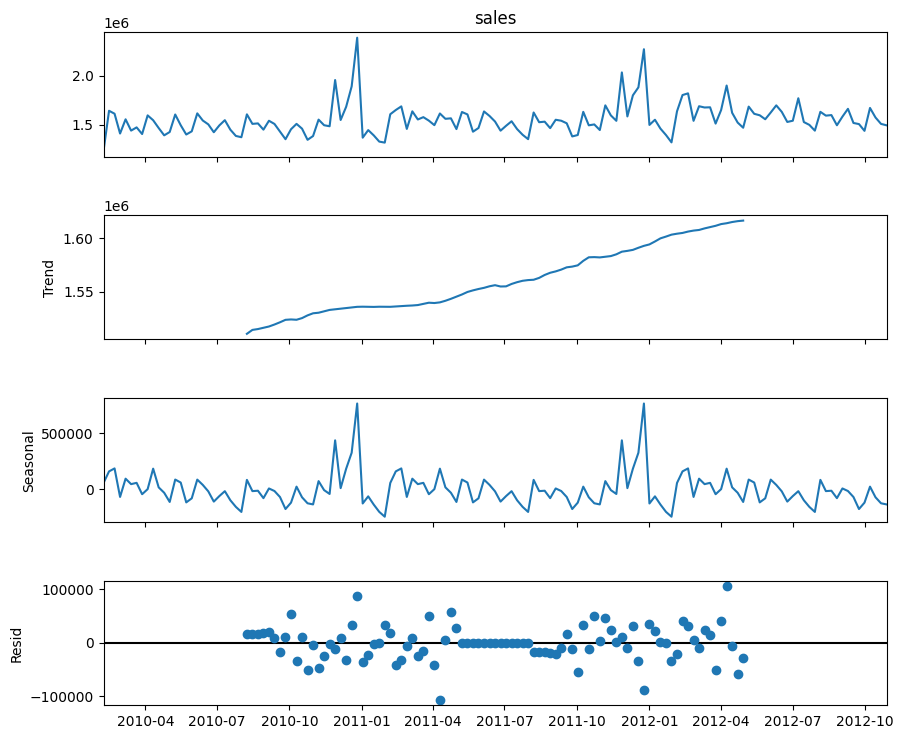

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010136 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1069
[LightGBM] [Info] Number of data points in the train set: 336391, number of used features: 7
[LightGBM] [Info] Start training from score 16025.631113

Model RMSE Results:
LinearRegression: 21456.4475
XGBoost: 21543.5855
LightGBM: 21445.2101


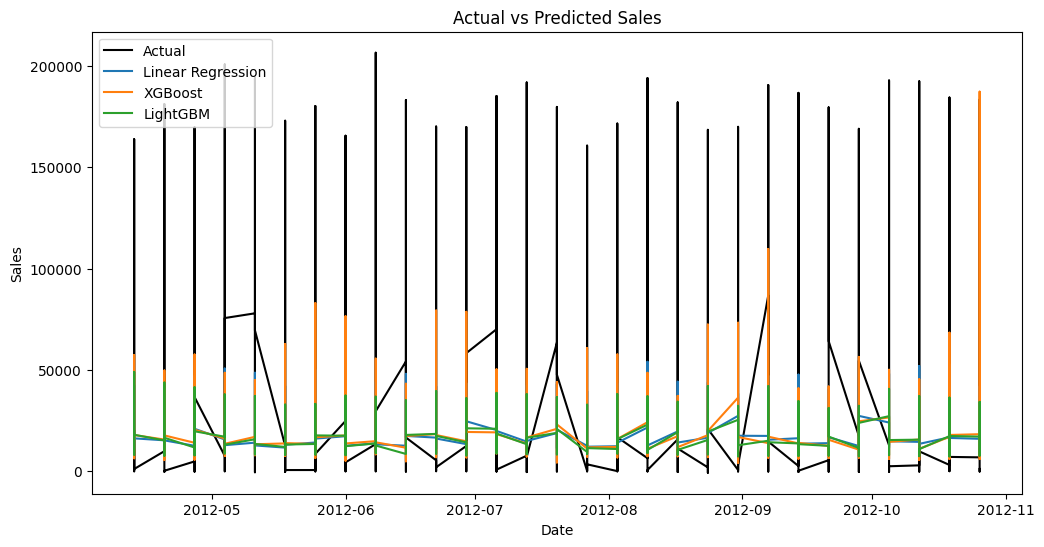

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

# Load Data
df = pd.read_csv("/content/train.csv", parse_dates=["Date"])
df = df.rename(columns={"Date": "date", "Weekly_Sales": "sales", "Store": "store"})

print(df.head())

# Sort by date
df = df.sort_values("date")

# Feature Engineering
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month
df["day"] = df["date"].dt.day
df["dayofweek"] = df["date"].dt.dayofweek

# Lag features
df["lag_1"] = df.groupby("store")["sales"].shift(1)
df["lag_7"] = df.groupby("store")["sales"].shift(7)

# Rolling averages
df["roll_mean_7"] = df.groupby("store")["sales"].shift(1).rolling(7).mean()
df["roll_mean_30"] = df.groupby("store")["sales"].shift(1).rolling(30).mean()

# Drop rows with NaN from lag/rolling
df = df.dropna()

# Seasonal Decomposition (Bonus)
store_example = df[df["store"] == 1].set_index("date").resample("W")["sales"].sum()
decomposition = seasonal_decompose(store_example, model="additive", period=52)

fig = decomposition.plot()
fig.set_size_inches(10, 8)
plt.show()

# Train-Test Split (Time Aware)
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

features = ["year", "month", "day", "dayofweek", "lag_1", "lag_7", "roll_mean_7", "roll_mean_30"]
X_train, y_train = train[features], train["sales"]
X_test, y_test = test[features], test["sales"]

# Models
results = {}

# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
results["LinearRegression"] = np.sqrt(mean_squared_error(y_test, y_pred_lr))

# XGBoost
xgbr = xgb.XGBRegressor(n_estimators=300, max_depth=6, learning_rate=0.1, random_state=42)
xgbr.fit(X_train, y_train)
y_pred_xgb = xgbr.predict(X_test)
results["XGBoost"] = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

# LightGBM
lgbm = lgb.LGBMRegressor(n_estimators=300, learning_rate=0.05, random_state=42)
lgbm.fit(X_train, y_train)
y_pred_lgb = lgbm.predict(X_test)
results["LightGBM"] = np.sqrt(mean_squared_error(y_test, y_pred_lgb))

print("\nModel RMSE Results:")
for k, v in results.items():
    print(f"{k}: {v:.4f}")

# Plot Actual vs Predicted
plt.figure(figsize=(12,6))
plt.plot(test["date"], y_test.values, label="Actual", color="black")
plt.plot(test["date"], y_pred_lr, label="Linear Regression")
plt.plot(test["date"], y_pred_xgb, label="XGBoost")
plt.plot(test["date"], y_pred_lgb, label="LightGBM")
plt.legend()
plt.title("Actual vs Predicted Sales")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()
